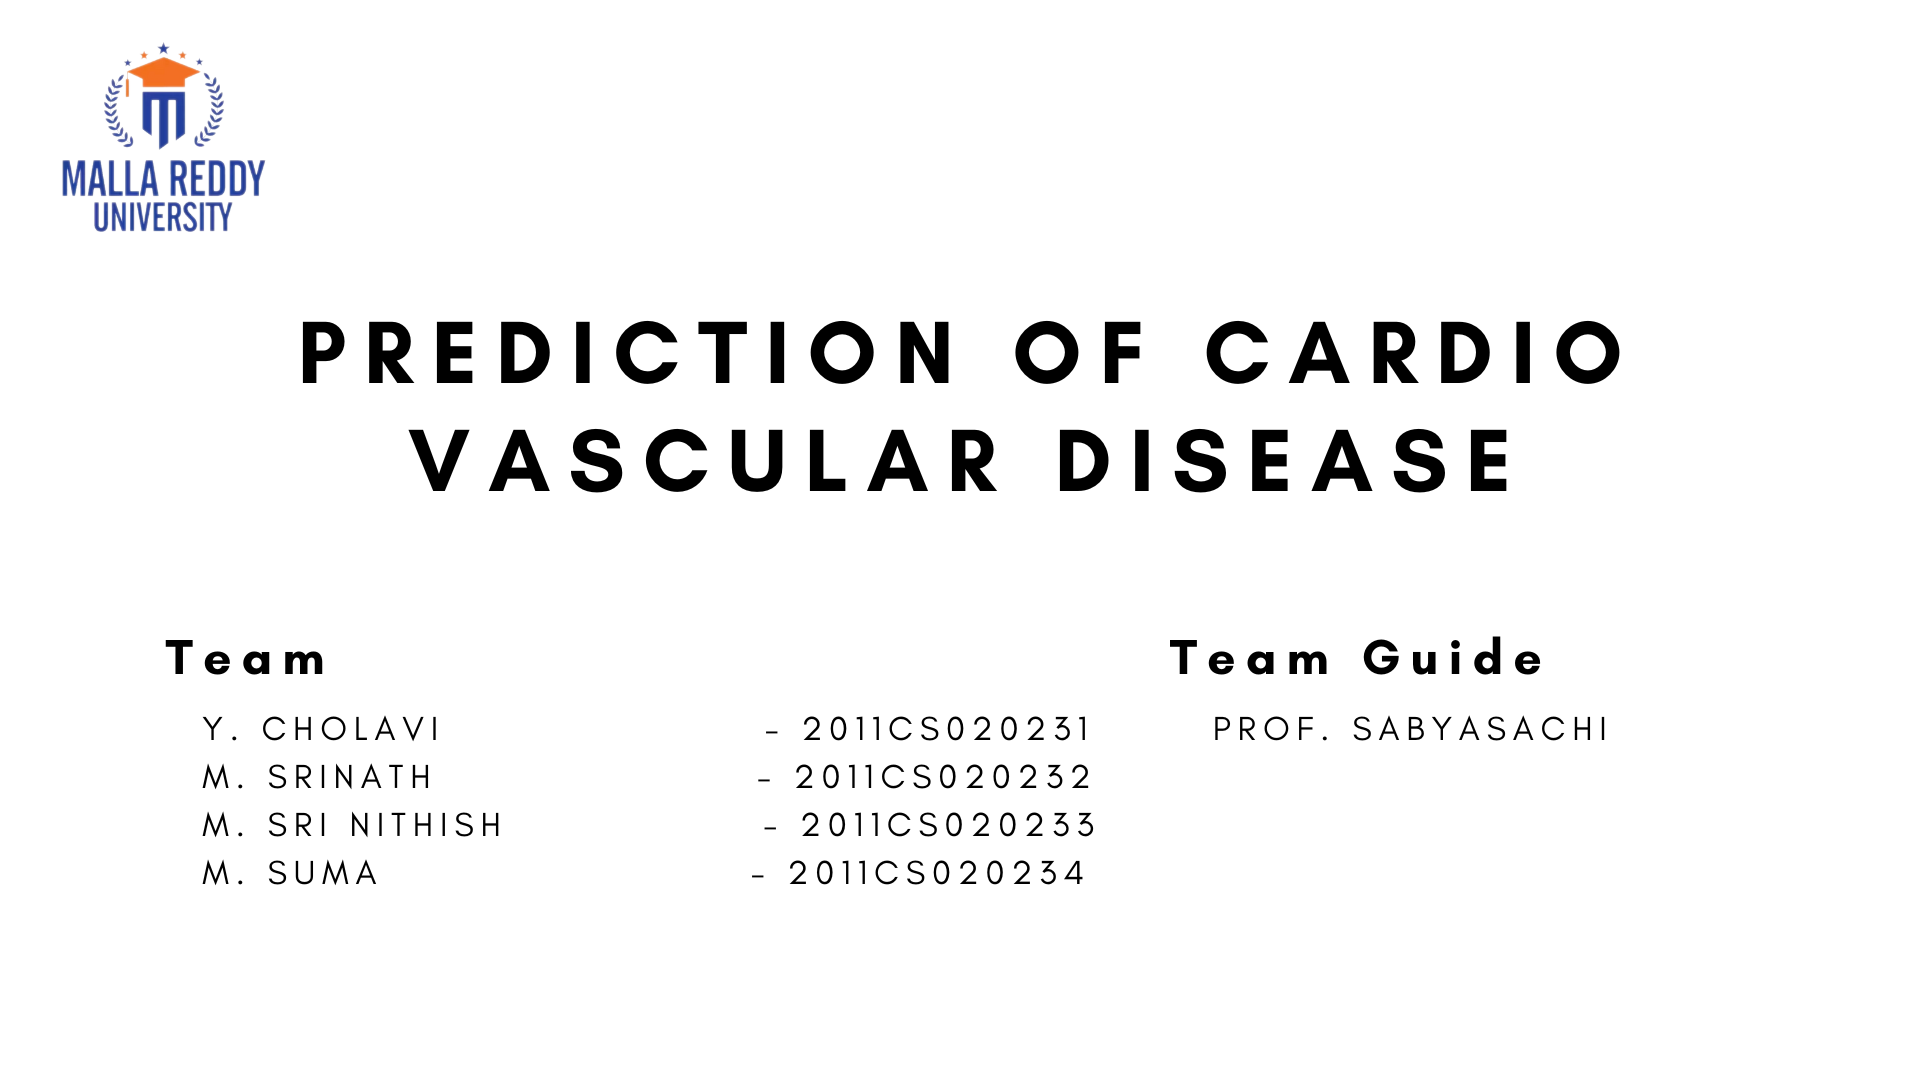

## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold

## Loading DataSet

In [2]:
df = pd.read_csv("C:\\Users\\NANDISH KUMAR\\OneDrive\\Desktop\\SRINATH\\ARRYTHMIA\\heart.csv")
print(df)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N  

### Checking for duplicates and Null Values

In [3]:
df.duplicated().sum()

0

In [4]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Data Info

In [5]:
df.shape

(918, 12)

In [6]:
for col in df.columns:
    print(f'{col} has {df[col].nunique()} unique values.')

Age has 50 unique values.
Sex has 2 unique values.
ChestPainType has 4 unique values.
RestingBP has 67 unique values.
Cholesterol has 222 unique values.
FastingBS has 2 unique values.
RestingECG has 3 unique values.
MaxHR has 119 unique values.
ExerciseAngina has 2 unique values.
Oldpeak has 53 unique values.
ST_Slope has 3 unique values.
HeartDisease has 2 unique values.


In [7]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
for col in cat_cols:
    print(f'The unique values in {col} are: {df[col].unique()}')

The unique values in Sex are: ['M' 'F']
The unique values in ChestPainType are: ['ATA' 'NAP' 'ASY' 'TA']
The unique values in FastingBS are: [0 1]
The unique values in RestingECG are: ['Normal' 'ST' 'LVH']
The unique values in ExerciseAngina are: ['N' 'Y']
The unique values in ST_Slope are: ['Up' 'Flat' 'Down']


## EXPLORATORY DATA ANLAYSIS

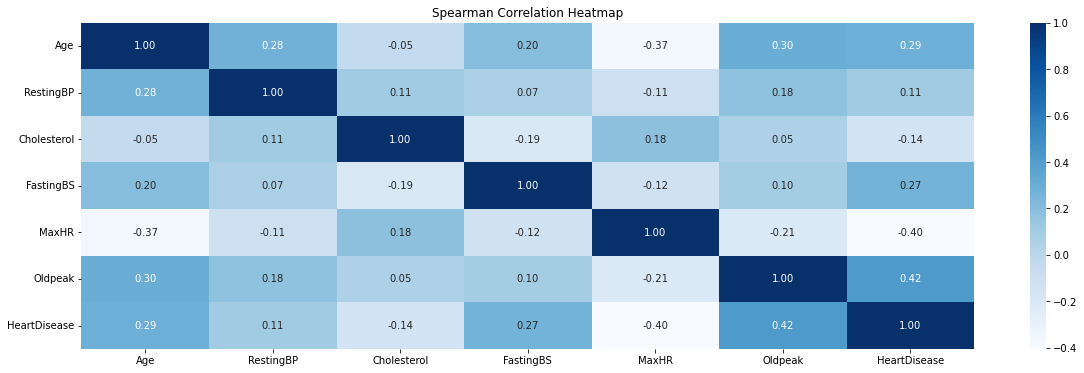

In [9]:
corr = df.corr(method = 'spearman')
plt.figure(figsize=(20,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Spearman Correlation Heatmap')
plt.show()

<Figure size 1440x720 with 0 Axes>

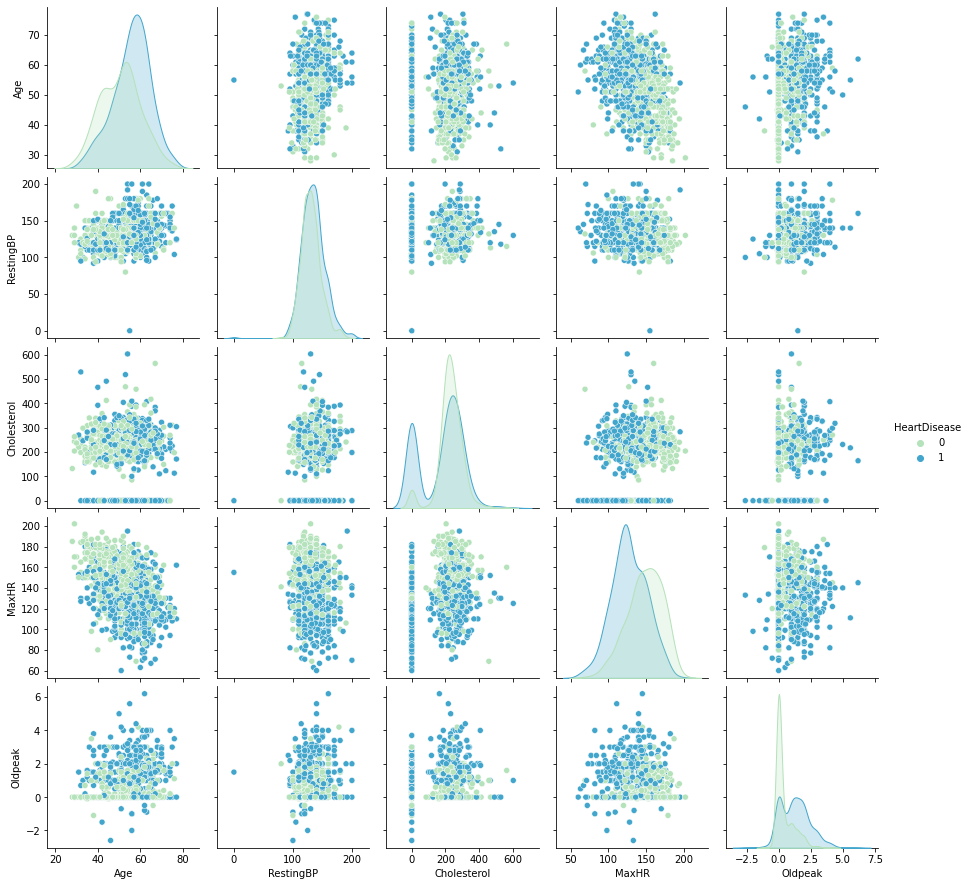

In [10]:
pairplot_cols = num_cols
pairplot_cols.append('HeartDisease')
figure = plt.figure(figsize=(20,10))
sns.pairplot(df[pairplot_cols], hue='HeartDisease', palette='GnBu')
plt.show()

In [11]:
df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()

172

In [12]:
df.loc[(df['Cholesterol']==0)&(df['HeartDisease']==1),'Cholesterol'].count()

152

In [13]:
num_cols.remove('Cholesterol')

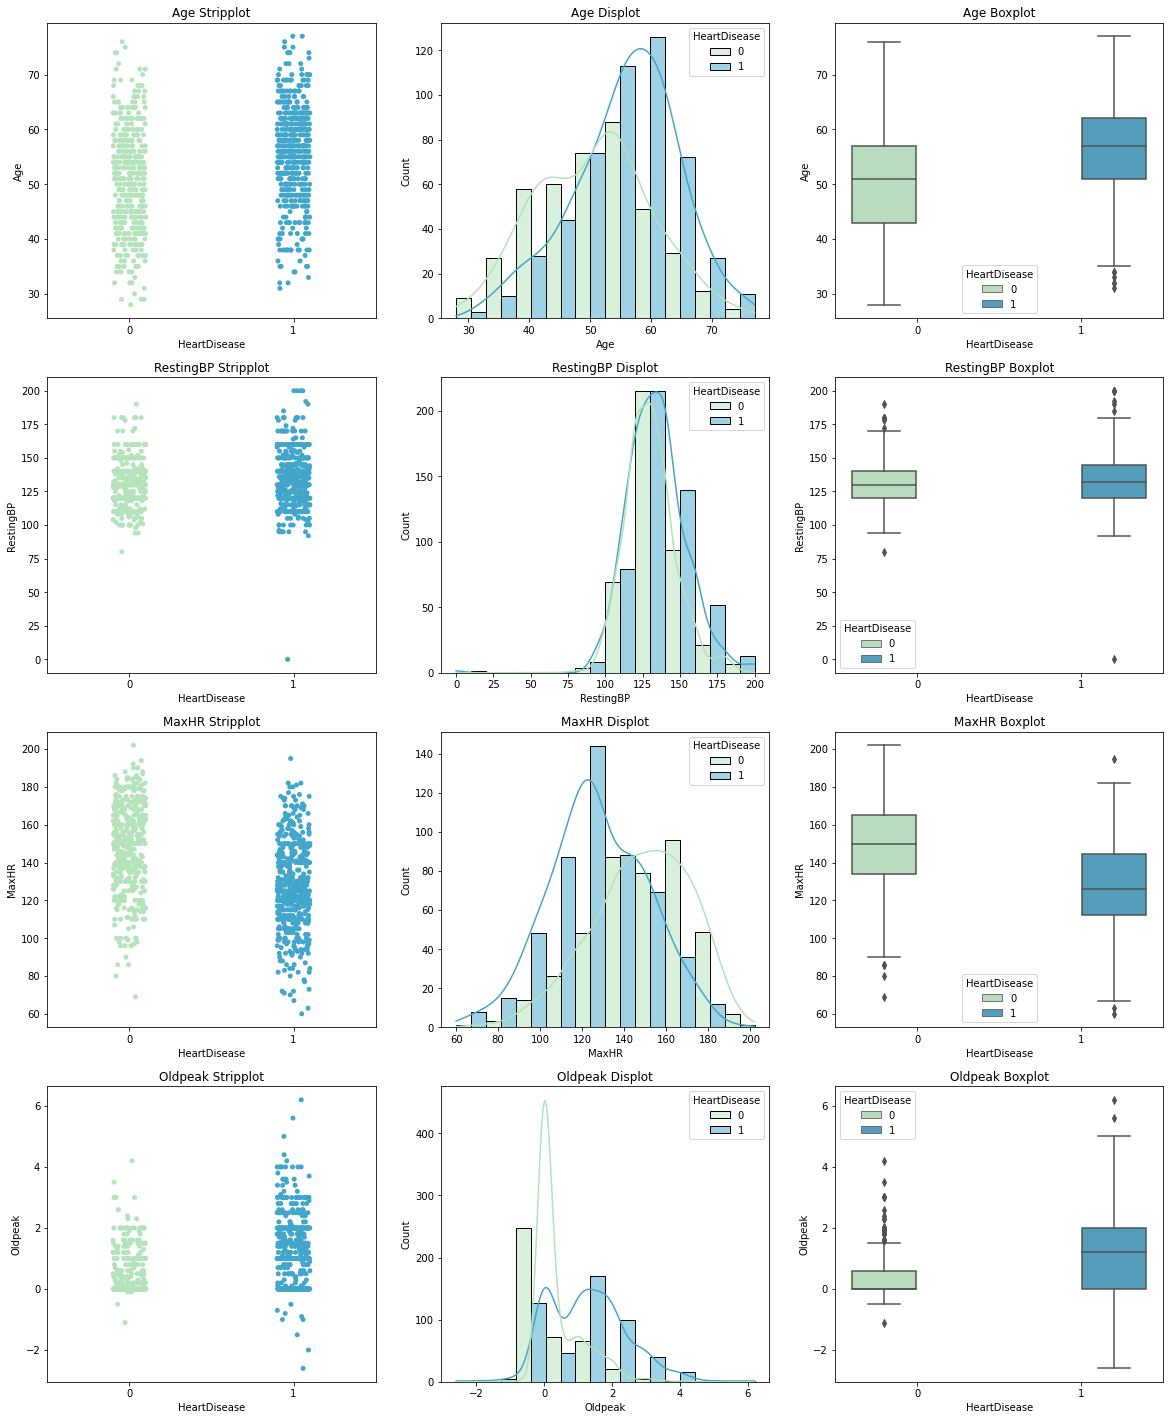

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(20,25))
for i, col in zip(range(4), num_cols):
    sns.stripplot(ax=axes[i][0], x='HeartDisease', y=col, data=df, palette='GnBu', jitter=True)
    axes[i][0].set_title(f'{col} Stripplot')
    sns.histplot(ax=axes[i][1], x=col, data=df, kde=True, bins=10, palette='GnBu', hue='HeartDisease', multiple='dodge')
    axes[i][1].set_title(f'{col} Displot')
    sns.boxplot(ax=axes[i][2], x='HeartDisease', y=col, data=df, palette='GnBu', hue='HeartDisease')
    axes[i][2].set_title(f'{col} Boxplot')

In [15]:
eda_num_cols = ['RestingBP','MaxHR','Oldpeak']

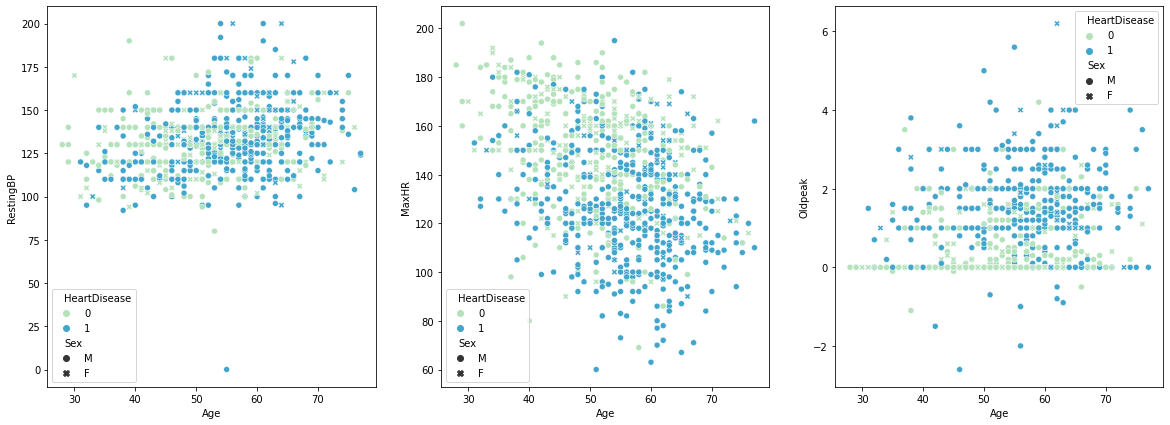

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
for i, col in zip(range(3), eda_num_cols):
    sns.scatterplot(ax=axes[i], x='Age', y=col, hue="HeartDisease", style="Sex", data=df.iloc[0:889,:], palette="GnBu")

## REPLACING OUTLIERS

In [17]:
def outlier_limits(df, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_limits(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit
    
for variable in df[num_cols].columns:
    replace_with_limits(df, variable)

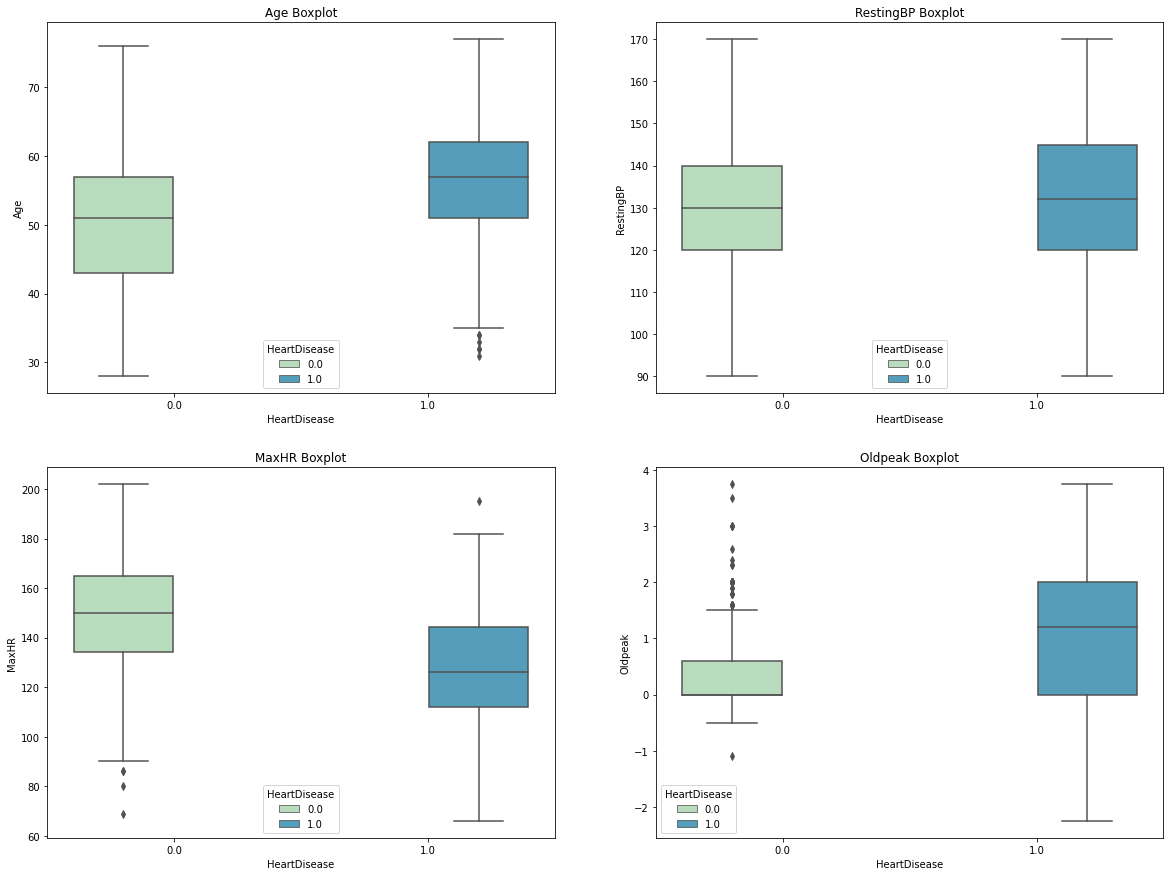

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
for i, col in zip(range(4), num_cols):
    sns.boxplot(ax=axes[i//2][i%2], x='HeartDisease', y=col, data=df, palette='GnBu', hue='HeartDisease')
    axes[i//2][i%2].set_title(f'{col} Boxplot')

## DATA PREPROCESSING

In [19]:
num_cols.remove('HeartDisease')

In [20]:
print(cat_cols)
print(num_cols)

['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
['Age', 'RestingBP', 'MaxHR', 'Oldpeak']


In [21]:
X = df.iloc[:,:11]
y = df['HeartDisease']
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49.0,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37.0,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48.0,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54.0,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [22]:
preprocessor1_features = ['x0_ASY', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Down', 'x1_Flat', 'x1_Up', 'x2_LVH', 'x2_Normal', 'x2_ST', 'x3_F', 'x3_M', 'x4_N', 'x4_Y', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol', 'FastingBS']
final_features = ['PC-1', 'PC-2', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Flat', 'x1_Up', 'x2_Normal', 'x2_ST', 'x3_M', 'x4_Y', 'FastingBS']

In [23]:
pca = PCA(n_components=2)
preprocessor1 = ColumnTransformer(
    transformers = [
        ('onehotcat', OneHotEncoder(), ['ChestPainType', 'ST_Slope', 'RestingECG', 'Sex', 'ExerciseAngina']),
        ('num', MinMaxScaler(), num_cols),
    ],
    remainder = 'passthrough',
)
preprocessor2 = ColumnTransformer(
    transformers = [
        ('pca', pca, num_cols),
        ('dropper', 'drop', ['x0_ASY', 'x1_Down', 'x2_LVH', 'x3_F', 'x4_N', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol'])
    ],
    remainder = 'passthrough',
)

In [24]:
X = pd.DataFrame(preprocessor1.fit_transform(X), columns=preprocessor1_features)
X = pd.DataFrame(preprocessor2.fit_transform(X), columns=final_features)
X.head()

,PC-1,PC-2,x0_ATA,x0_NAP,x0_TA,x1_Flat,x1_Up,x2_Normal,x2_ST,x3_M,x4_Y,FastingBS
0,0.268472,0.314646,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,-0.094260,0.372504,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.136854,-0.067667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,-0.105074,-0.037640,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.136472,0.120718,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Splitting Test Data and Training Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Defining Some functions

In [26]:
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Feature', 'VIF'])
    x_var_names = X.columns
    for i in range(0, x_var_names.shape[0]):
        y = X[x_var_names[i]]
        x = X[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'VIF', axis = 0, ascending=False, inplace=False)

calculate_vif(X)

,Feature,VIF
9,x3_M,4.38
5,x1_Flat,4.10
6,x1_Up,4.06
7,x2_Normal,3.67
10,x4_Y,2.35
8,x2_ST,1.90
2,x0_ATA,1.75
3,x0_NAP,1.51
0,PC-1,1.38
11,FastingBS,1.37


In [27]:
def fit(clf, params, cv=10, X_train=X_train, y_train=y_train):
    grid = GridSearchCV(clf, params, cv=KFold(n_splits=cv), n_jobs=1, verbose=1, return_train_score=True, scoring='accuracy', refit=True) #verbose and n_jobs help us see the computation time and score of a cv. Higher the value of verbose, more the information printed out.
    grid.fit(X_train, y_train)
    return grid

def make_predictions(model, X_test=X_test):
    return model.predict(X_test)

def best_scores(model):
    print(f'The best parameters are: {model.best_params_}')
    print(f'The best score that we got is: {model.best_score_}')
    return None

def plot_confusion_matrix(y_pred):
    print('00: True Negatives\n01: False Positives\n10: False Negatives\n11: True Positives\n')
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap='GnBu', alpha=0.75)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large') 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    return None

def check_scores(y_pred):
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    print('ROC-AUC Score: %.3f' % roc_auc_score(y_test, y_pred))
    return None


# Classifiers

## Logistic Regression

In [28]:
lr_params = {'C':[0.001,.009,0.01,.09,1,5,10,25], 'penalty':['l1', 'l2']} #lasso and ridge regression
lr_clf = LogisticRegression(solver='saga', max_iter=5000)
lr_model = fit(lr_clf, lr_params)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [29]:
best_scores(lr_model)

The best parameters are: {'C': 0.09, 'penalty': 'l2'}
The best score that we got is: 0.8554609403924471


In [30]:
lr_y_pred = make_predictions(lr_model)
check_scores(lr_y_pred)

Precision: 0.873
Recall: 0.873
Accuracy: 0.859
F1 Score: 0.873
ROC-AUC Score: 0.857


In [31]:
acc1 = accuracy_score(y_test, lr_y_pred)

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



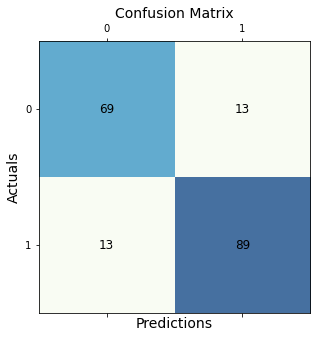

In [32]:
plot_confusion_matrix(lr_y_pred)


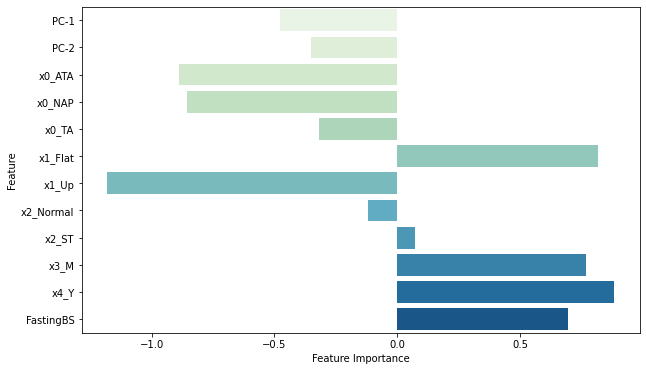

In [33]:
lr_feature_scores = lr_model.best_estimator_.coef_[0].tolist()
lr_fi = pd.DataFrame({'Feature': final_features, 'Feature Importance': lr_feature_scores})
plt.figure(figsize=(10,6))
sns.barplot(x='Feature Importance', y='Feature', data=lr_fi, palette='GnBu')
plt.show()

## Gaussian Naive  Bayes

In [34]:
gnb_params = {'priors': [None], 'var_smoothing': np.logspace(0,-9, num=100)}
gnb_clf = GaussianNB()
gnb_model = fit(gnb_clf, gnb_params)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [35]:
best_scores(gnb_model)

The best parameters are: {'priors': None, 'var_smoothing': 0.08111308307896872}
The best score that we got is: 0.8554794520547946


In [36]:
gnb_y_pred = make_predictions(gnb_model)
check_scores(gnb_y_pred)

Precision: 0.898
Recall: 0.863
Accuracy: 0.870
F1 Score: 0.880
ROC-AUC Score: 0.870


In [37]:
acc2 = accuracy_score(y_test, gnb_y_pred)

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



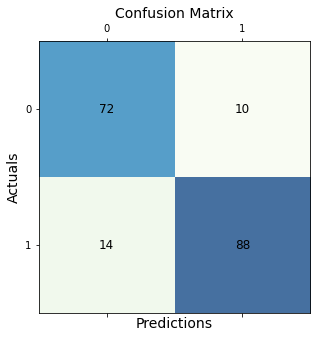

In [38]:
plot_confusion_matrix(gnb_y_pred)

## K-NN

In [39]:
knns_params = {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance'], 
               'metric': ['euclidean', 'manhattan']}
knns_clf = KNeighborsClassifier()
knns_model = fit(knns_clf, knns_params)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


In [40]:
knns_y_pred = make_predictions(knns_model)
check_scores(knns_y_pred)


Precision: 0.877
Recall: 0.912
Accuracy: 0.880
F1 Score: 0.894
ROC-AUC Score: 0.877


In [41]:
acc3 = accuracy_score(y_test, knns_y_pred)

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



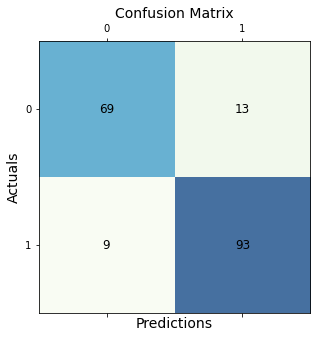

In [42]:
plot_confusion_matrix(knns_y_pred)

## SVM

In [43]:
svm_params = {'C':[1,10,100,1000], 'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
svm_clf = SVC()
svm_model = fit(svm_clf, svm_params)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


In [44]:
best_scores(svm_model)

The best parameters are: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
The best score that we got is: 0.8567937800814512


In [45]:
svm_y_pred = make_predictions(svm_model)
check_scores(svm_y_pred)

Precision: 0.847
Recall: 0.922
Accuracy: 0.864
F1 Score: 0.883
ROC-AUC Score: 0.857


In [46]:
acc4 = accuracy_score(y_test, svm_y_pred)

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



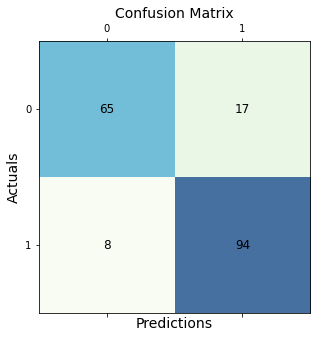

In [47]:
plot_confusion_matrix(svm_y_pred)

## Decision Tree

In [48]:
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,10), 
             'min_samples_leaf': range(1,5)}
dt_clf = DecisionTreeClassifier()
dt_model = fit(dt_clf, dt_params)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [49]:
best_scores(dt_model)


The best parameters are: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
The best score that we got is: 0.8363569048500554


In [50]:
dt_y_pred = make_predictions(dt_model)
check_scores(dt_y_pred)

Precision: 0.850
Recall: 0.833
Accuracy: 0.826
F1 Score: 0.842
ROC-AUC Score: 0.825


In [51]:
acc5 = accuracy_score(y_test, dt_y_pred)

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



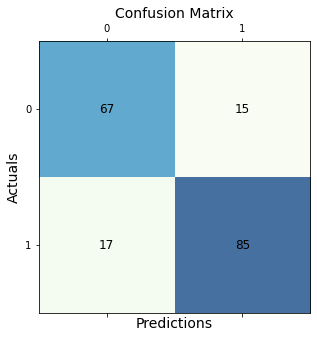

In [52]:
plot_confusion_matrix(dt_y_pred)

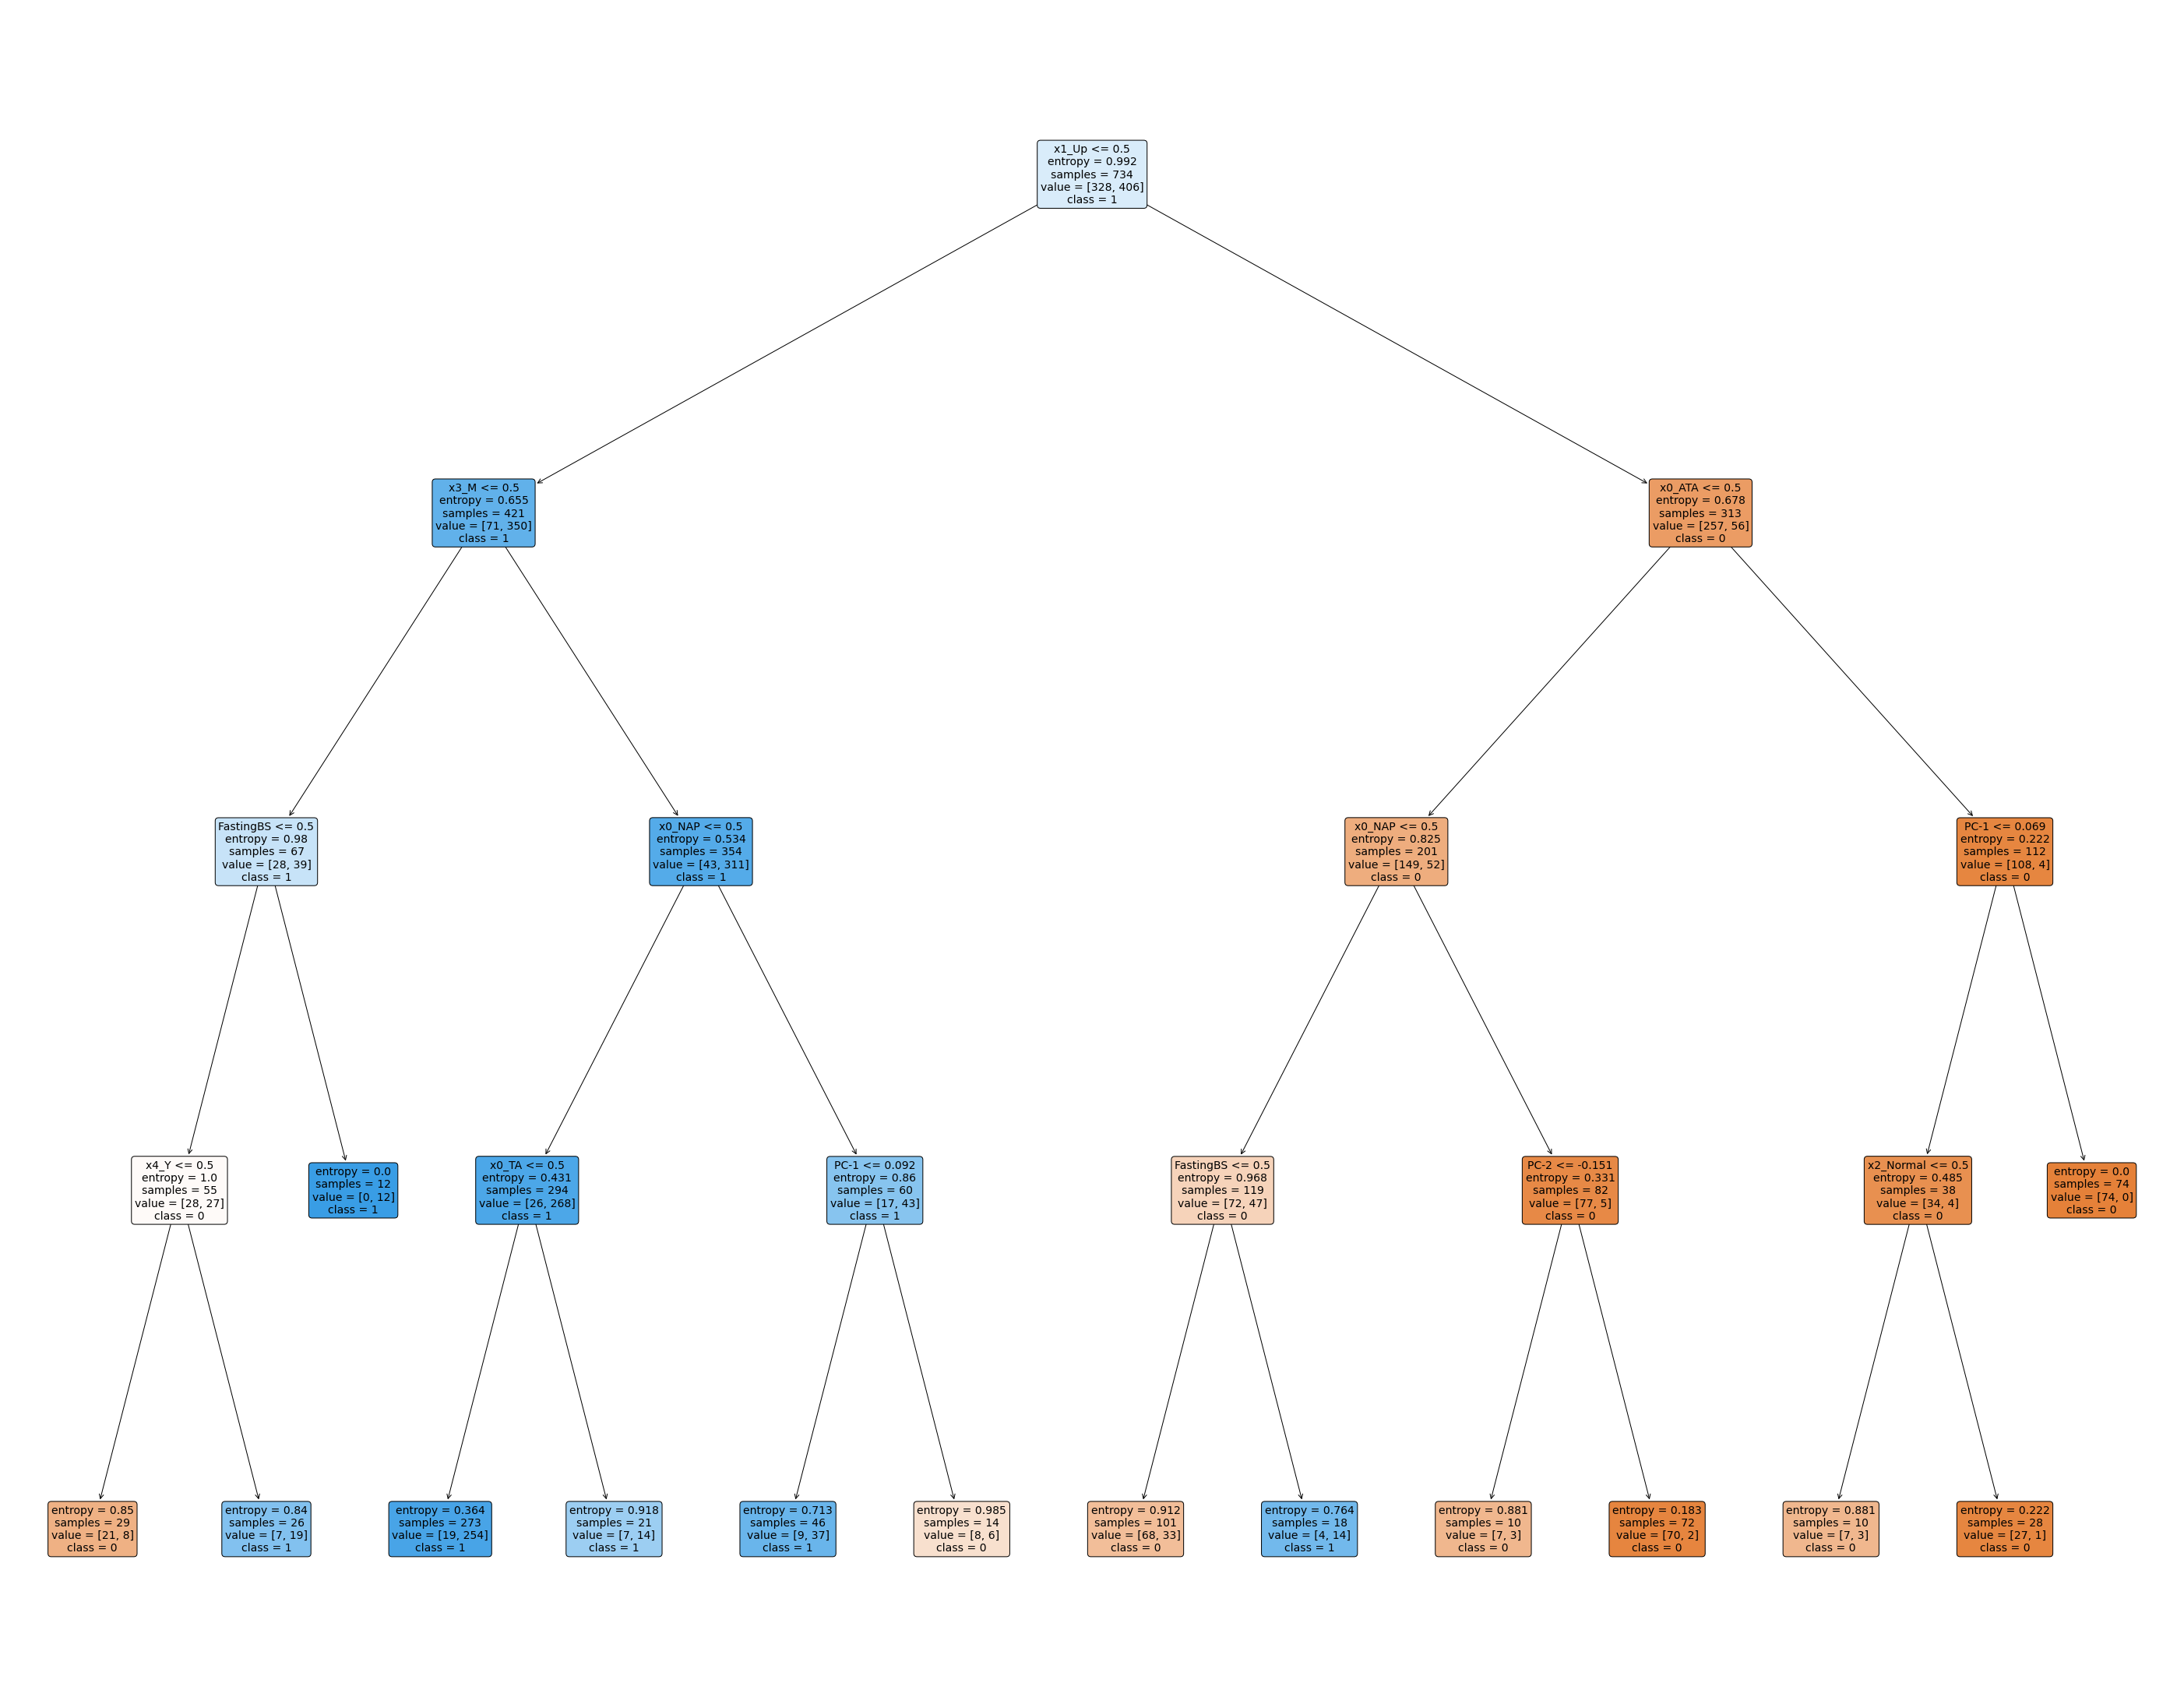

In [53]:
fig = plt.figure(figsize=(50,40))
tree.plot_tree(dt_model.best_estimator_, feature_names=final_features,  class_names=['0','1'], filled=True, fontsize=14, rounded=True)
plt.show()

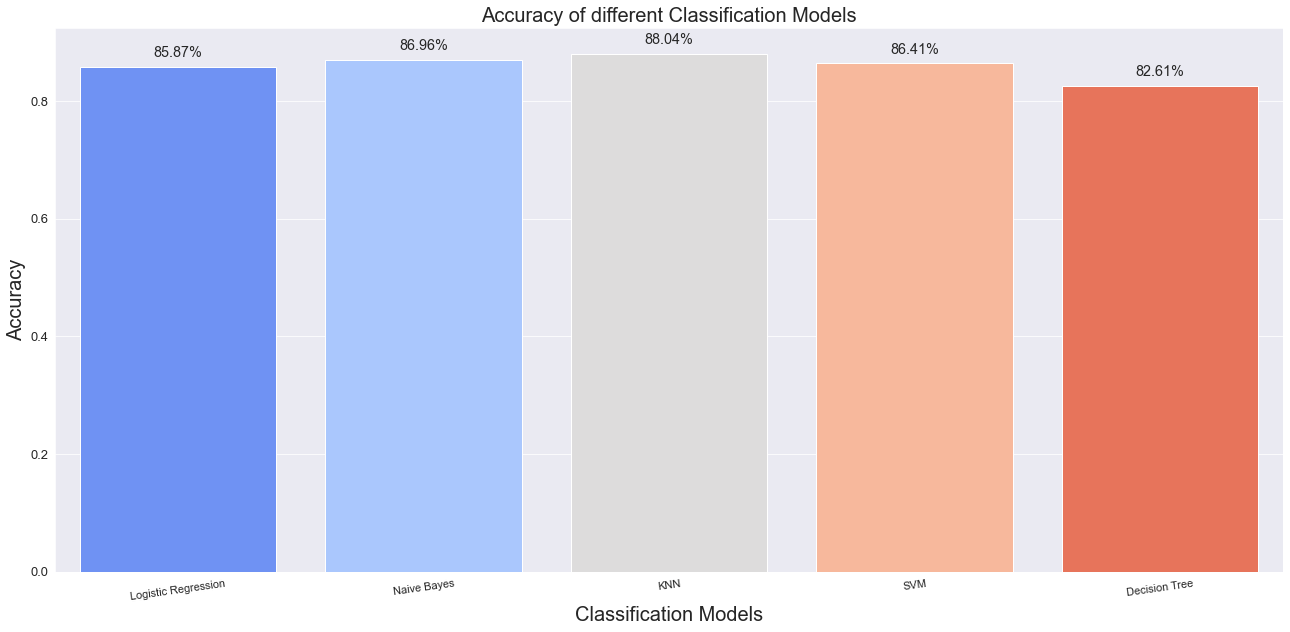

In [54]:
mylist=[]
mylist2=[]
mylist.append(acc1)
mylist2.append("Logistic Regression")
mylist.append(acc2)
mylist2.append("Naive Bayes")
mylist.append(acc3)
mylist2.append("KNN")
mylist.append(acc4)
mylist2.append("SVM")
mylist.append(acc5)
mylist2.append("Decision Tree")
plt.rcParams['figure.figsize']=22,10
sns.set_style("darkgrid")
ax = sns.barplot(x=mylist2, y=mylist, palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()